## Preparation

install the original model xgboost-1.4.2

In [3]:
!pip3 uninstall -y xgboost
!pip3 install xgboost==1.4.2

Found existing installation: xgboost 1.7.6
Uninstalling xgboost-1.7.6:
  Successfully uninstalled xgboost-1.7.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 3.0 MB/s eta 0:00:00


install TransBoost based on xgboost-1.4.2

In [4]:
import os
import imp
xgb_path = imp.find_module("xgboost")[1]

os.system('cp '+xgb_path+'/__init__.py '+xgb_path+'/__init__.py.bak')
os.system('cp '+xgb_path+'/core.py '+xgb_path+'/core.py.bak')
os.system('cp '+xgb_path+'/sklearn.py '+xgb_path+'/sklearn.py.bak')
os.system('cp '+xgb_path+'/training.py '+xgb_path+'/training.py.bak')
# Install TransBoost
os.system('cp ./TransBoost/*.py '+xgb_path+'/')
print('Installation succeeded.')

Installation succeeded.


## Dataset 1: UCI WineQuality Dataset

We set red wine as the source domain and white wine as the target domain.  
Use 3,918 labeled source instances and 500 labeled target instances for training, and 960 target instances for testing. Our goal is to classify the few excellent or poor white wines.


### Data Preprocessing

In [5]:
import numpy as np
import pandas as pd

## Load data
target_wine = pd.read_csv('data/winequality-red.csv', sep = ';')
source_wine = pd.read_csv('data/winequality-white.csv', sep = ';')
target_wine['label'] = [0 if t <=5 else 1 for t in target_wine['quality']]
source_wine['label'] = [0 if t <=5 else 1 for t in source_wine['quality']]
column_selected = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'label']
target_wine = target_wine[column_selected]
source_wine = source_wine[column_selected]

## Data
source = source_wine
target = target_wine

## parameter
size_tt = range(50,550,50) #Sample Size - Target domain for Training
source_test_size = 0.2
target_test_size = 0.6

In [6]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  label                 4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [7]:
source.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [8]:
target.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Model Evaluation

In [9]:
# Experiment: Evaluate the model given different sample size of traget domain for training

import xgboost
from imp import reload
reload(xgboost)
from xgboost import TransBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

result = []

for size in size_tt:

    # Train-Test split
    source_train,source_test = train_test_split(source, test_size = source_test_size, random_state=952)
    target_train,target_test = train_test_split(target, test_size = target_test_size, random_state=952)
    target_train = target_train.sample(n = size, random_state = 123)

    X_source_train = source_train.reset_index(drop = True).drop(['label'], axis = 1)
    Y_source_train = source_train.reset_index(drop = True).label
    X_source_test = source_test.reset_index(drop = True).drop(['label'], axis = 1)
    Y_source_test = source_test.reset_index(drop = True).label
    X_target_train = target_train.reset_index(drop = True).drop(['label'], axis = 1)
    Y_target_train = target_train.reset_index(drop = True).label
    X_target_test = target_test.reset_index(drop = True).drop(['label'], axis = 1)
    Y_target_test = target_test.reset_index(drop = True).label

    # Data normalization
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    X_target_train = min_max_scaler.fit_transform(X_target_train)
    X_target_test = min_max_scaler.transform(X_target_test)
    X_source_train = min_max_scaler.transform(X_source_train)
    X_source_test = min_max_scaler.transform(X_source_test)

    # TransBoostClassifier
    clf = TransBoostClassifier(max_depth = 4,
                  learning_rate = 0.1,
                  n_estimators = 40,
                  min_child_weight = 0,
                  reg_alpha = 0.,
                  reg_lambda = 1.,
                  objective = 'binary:logistic',
                  seed = 1440,
                  transfer_decay_ratio = 2.,
                  transfer_velocity = 1. ,
                  transfer_rebalance = False,
                  transfer_min_leaf_size = 10,
                  transfer_prior_margin = 'mirror',
                  transfer_margin_estimation = 'firstorder',
                  verbosity = 0,
                  nthread = 64)
    # Fit the model
    tb_model=clf.fit(X_source_train, Y_source_train, X_target_train, Y_target_train)
    y_pred_target_test=tb_model.predict_proba(X_target_test)[:,1]
    result.append([size,roc_auc_score(Y_target_test, y_pred_target_test)])

result=pd.DataFrame(result)
result.columns=['TargetDomainSize','AUC']
print(result)

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


TransBoost Dev Version 0.4
TransBoost Dev Version 0.4
   TargetDomainSize       AUC
0                50  0.780237
1               100  0.807164
2               150  0.806666
3               200  0.813394
4               250  0.813143
5               300  0.824964
6               350  0.820426
7               400  0.817290
8               450  0.820424
9               500  0.835062


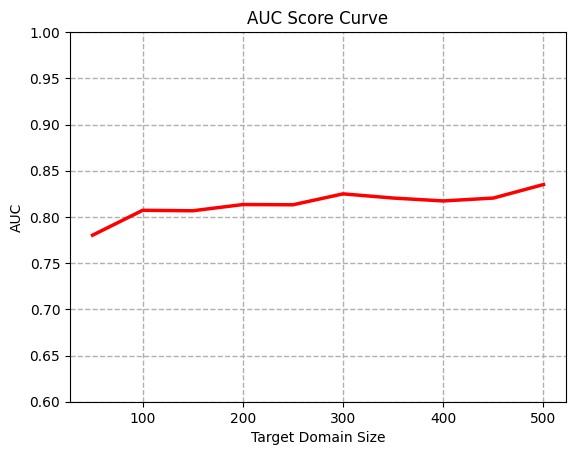

In [10]:
import matplotlib.pyplot as plt
#AUC score visualization
plt.plot(result['TargetDomainSize'], result['AUC'], color='r', linewidth=2.5)
plt.grid(linestyle='--', linewidth=1)
plt.ylim([min(result['AUC'].any(), 0.60), 1.00])
plt.title('AUC Score Curve')
plt.xlabel('Target Domain Size')
plt.ylabel('AUC');

## Dataset 2: Lending Club Dataset


### Data Preprocessing

We set the medical loans as the source domain and the car loans as the target domain.  
Use 5,080 labeled source instances and 1,000 labeled target instances for training, and 3,000 target instances for testing.


In [11]:
import numpy as np
import pandas as pd
import pickle
## Load data
club = pickle.load(open('./data/club.pkl','rb'))

# Source Domain: medical; Target Domain: car

source_club = club[club.purpose == 'medical']
target_club = club[club.purpose == 'car']

source_club = source_club.drop(['purpose', 'year'], axis=1)
target_club = target_club.drop(['purpose', 'year'], axis=1)

## Data
source = source_club
target = target_club

## parameter
size_tt = range(100,1100,100) #Sample Size - Target domain for Training
size_st = 5000 #Sample Size - Source domain for Training
size_test = 3000 #Sample Size - Target domian for Testing
source_test_size = 0.2
target_test_size = 0.75

In [12]:
pd.options.display.max_info_columns = 120
source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 58 to 501634
Data columns (total 111 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    loan_amnt                            5080 non-null   float64
 1    funded_amnt                          5080 non-null   float64
 2    funded_amnt_inv                      5080 non-null   float64
 3    int_rate                             5080 non-null   float64
 4    installment                          5080 non-null   float64
 5    annual_inc                           5080 non-null   float64
 6    dti                                  5080 non-null   float64
 7    delinq_2yrs                          5080 non-null   float64
 8    fico_range_low                       5080 non-null   float64
 9    fico_range_high                      5080 non-null   float64
 10   inq_last_6mths                       5080 non-null   float64
 11   open_acc    

In [13]:
source.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,label
58,5000.0,5000.0,5000.0,0.1075,163.11,38000.0,17.88,0.0,665.0,669.0,...,0,0,0,0,0,0,0,1,0,0
201,25000.0,25000.0,25000.0,0.0975,803.75,93000.0,14.60,0.0,725.0,729.0,...,0,0,0,0,0,0,0,1,0,0
400,5000.0,5000.0,5000.0,0.1446,172.01,100000.0,12.13,1.0,665.0,669.0,...,0,0,0,0,0,0,0,0,0,0
463,3600.0,3600.0,3600.0,0.1727,128.84,90000.0,27.80,0.0,695.0,699.0,...,0,0,0,0,0,0,0,1,0,0
823,12000.0,12000.0,12000.0,0.0532,361.38,39000.0,3.51,0.0,770.0,774.0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
target.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,label
161,4000.0,4000.0,4000.0,0.0697,123.46,94500.0,10.07,0.0,720.0,724.0,...,0,0,0,0,0,0,0,1,0,0
365,11200.0,11200.0,11200.0,0.1367,258.70,65000.0,28.90,0.0,720.0,724.0,...,0,0,0,0,0,0,0,1,0,0
426,7200.0,7200.0,7200.0,0.0839,226.92,197000.0,8.08,0.0,675.0,679.0,...,0,0,0,0,0,0,0,1,0,0
574,6000.0,6000.0,6000.0,0.1727,214.73,90000.0,36.64,1.0,705.0,709.0,...,0,0,0,0,0,0,0,1,0,0
658,2400.0,2400.0,2350.0,0.2118,90.65,18200.0,5.21,0.0,695.0,699.0,...,0,0,0,0,0,0,0,0,0,0


### Model Evaluation

In [15]:
# Experiment: Evaluate the model given different sample size of traget domain for training

from xgboost import TransBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

result = []
for size in size_tt:

    # Train-Test split
    target_train,target_test=train_test_split(target, test_size = target_test_size, random_state = 952)
    source_train = source
    target_train = target_train.sample(n = 1000, random_state = 123)
    target_test = target_test.sample(n = size_test, random_state = 123)
    target_train = target_train.sample(n = size, random_state = 456)

    X_source_train = source_train.reset_index(drop = True).drop(['label'], axis = 1)
    Y_source_train = source_train.reset_index(drop = True).label
    X_target_train = target_train.reset_index(drop = True).drop(['label'], axis = 1)
    Y_target_train = target_train.reset_index(drop = True).label
    X_target_test = target_test.reset_index(drop = True).drop(['label'], axis = 1)
    Y_target_test = target_test.reset_index(drop = True).label

    # Data normalization
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    X_target_train = min_max_scaler.fit_transform(X_target_train)
    X_target_test = min_max_scaler.transform(X_target_test)
    X_source_train = min_max_scaler.transform(X_source_train)

    # TransBoostClassifier
    clf = TransBoostClassifier(max_depth=4,
                  learning_rate=0.1,
                  n_estimators=40,
                  min_child_weight=0,
                  reg_alpha=0.,
                  reg_lambda=1.,
                  objective='binary:logistic',
                  seed=1440,
                  transfer_decay_ratio = 2.,
                  transfer_velocity = 1. ,
                  transfer_rebalance = False,
                  transfer_min_leaf_size = 10,
                  transfer_prior_margin = 'mirror',
                  transfer_margin_estimation = 'firstorder',
                  verbosity = 0,
                  nthread=64)
    # Fit the model
    tb_model = clf.fit(X_source_train, Y_source_train, X_target_train, Y_target_train)
    y_pred_target_test = tb_model.predict_proba(X_target_test)[:,1]
    result.append([size,roc_auc_score(Y_target_test, y_pred_target_test)])

result=pd.DataFrame(result)
result.columns=['TargetDomainSize','AUC']
print(result)

   TargetDomainSize       AUC
0               100  0.721155
1               200  0.725305
2               300  0.728326
3               400  0.723564
4               500  0.723419
5               600  0.724404
6               700  0.721393
7               800  0.724029
8               900  0.726738
9              1000  0.723092


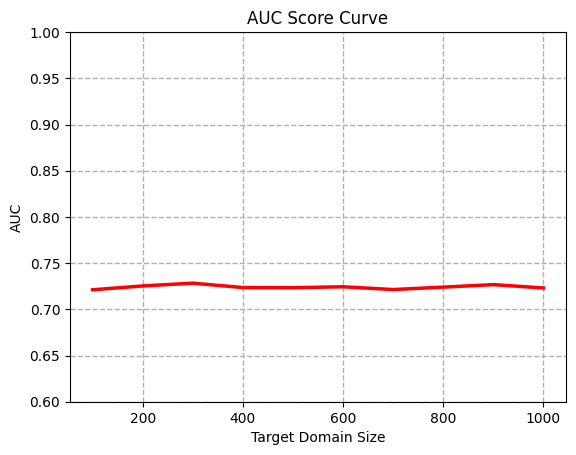

In [16]:
import matplotlib.pyplot as plt
#AUC score visualization
plt.plot(result['TargetDomainSize'], result['AUC'], color='r', linewidth=2.5)
plt.grid(linestyle='--', linewidth=1)
plt.ylim([min(result['AUC'].any(), 0.60), 1.00])
plt.title('AUC Score Curve')
plt.xlabel('Target Domain Size')
plt.ylabel('AUC');